<a href="https://colab.research.google.com/github/AnnaMHua/QuantumMentorship/blob/master/problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Mentorship Problem 1
In this report, we will study a certain type of parametrized quantum circuit. After optimizetion of the parameters $\vec{\theta}$ with respect to distance $\left \| |\psi(\theta)>-|\phi>\right\|$ ,the output quantum state of this quantum circuit $|\psi(\theta)>$  will be able to mimic any given random quantum state $|\phi>$. 
1. [Installing packages](#installation)
2. [Quantum circuit setup](#setup)
3. [Optimization of cost function](#optimization)
4. [Try other parametrized gates](#bonus)
5. [Try different entanglement](#entanglement)

## 1.Installing necessary packages <a name="installation"></a>
This notebook requires several packages including [```Qiskit```](https://qiskit.org/), an open source software development kit for quantum computing. 

In [1]:
# Run this cell for packages' installation. The outputs will be cleared at the end.
!pip install qiskit
!pip install matplotlib
from IPython.display import clear_output
clear_output()

## 2. Quantum circuit setup <a name="setup"></a>
We need to create a parametrized quantum circuit constructed by $L$ layers of odd and even quantum gates blocks.

Buliding blocks of this quantum circuit:
* 4 qbits, with $2^4$ degrees of freedom
* Odd blocks: parametrized $R_x$ gates operate on each qbit

* Even blocks: parametrized $R_z$ gates operate on each qbit, ```CZ``` gates operate on all qbit pairs to achieve full entanglement.

In [2]:
# Use qiskit to build and simulate quantum circuit
from qiskit import QuantumRegister, QuantumCircuit, quantum_info
from qiskit.circuit import ParameterVector
import numpy as np
from math import pi
from scipy.optimize import  minimize

#generate a random tagert 4 qbits state
target_state = quantum_info.random_statevector(2**4).data

#build the even blocks of quantum gates
def evengate(given_circuit, theta_list):

    #operate parmetrized Rz gates on each qbit
    for i in range(given_circuit.num_qubits):
        given_circuit.rz(theta_list[i],i)
    
    #operate CZ gates on each pair of qbits
    for i in range(given_circuit.num_qubits -1):
        for j in range(i+1,given_circuit.num_qubits):
            given_circuit.cz(i,j)

    return given_circuit

# visualize the random even block
theta = ParameterVector('θ',length=4)
print("Even Gate::")
evengate(QuantumCircuit(QuantumRegister(4)),theta).draw()

Even Gate::


┌──────────┐                  
q0_0: ┤ RZ(θ[0]) ├─■──■──■──────────
      ├──────────┤ │  │  │          
q0_1: ┤ RZ(θ[1]) ├─■──┼──┼──■──■────
      ├──────────┤    │  │  │  │    
q0_2: ┤ RZ(θ[2]) ├────■──┼──■──┼──■─
      ├──────────┤       │     │  │ 
q0_3: ┤ RZ(θ[3]) ├───────■─────■──■─
      └──────────┘

In [3]:
#build the odd blocks of quantum gates
def oddgate(given_circuit, theta_list):
    
     #operate parmetrized Rx gates on each qbit
    for i in range(given_circuit.num_qubits):
        given_circuit.rx(theta_list[i],i)
  
    return given_circuit

# visualize the random odd block
print("Odd Gate::")
oddgate(QuantumCircuit(QuantumRegister(4)),theta).draw()

Odd Gate::


┌──────────┐
q1_0: ┤ RX(θ[0]) ├
      ├──────────┤
q1_1: ┤ RX(θ[1]) ├
      ├──────────┤
q1_2: ┤ RX(θ[2]) ├
      ├──────────┤
q1_3: ┤ RX(θ[3]) ├
      └──────────┘

Now we can build $L$ layers of quantum circuit:

In [4]:
#bulid L layers of odd and even blocks for a 4 qbit quantum circuit
def get_var_form( parameters, L ):
    #initiallize a quantm circuit with 4 qbits, and its parameters with respect to layer L
    mycircuit = QuantumCircuit(QuantumRegister(4))
    parameter = parameters.reshape((L,8))

    #add L layers of odd and even blocks
    for i in range(L):
        oddgate(mycircuit, parameter[i][0:4])
        mycircuit.barrier()
        evengate(mycircuit, parameter[i][4:8])
        mycircuit.barrier()
    return mycircuit

## 3. Optimization of cost function(distance function) <a name="optimization"></a>
For a quantum circuit with parameters $\vec{\theta}$ and initial state $|0000>$, the distance between circuit output state $|\psi(\vec{\theta})>$ and a given random state $|\phi>$ is denoted by $$d(\vec{\theta}) = \left \| |\psi(\vec{\theta})>-|\phi>\right\|=\sum_i||\psi_i(\vec{\theta})>-|\phi_i>|^2$$

In the following we will define the distance function(or called cost function) $d(\vec{\theta})$ and  run the circuit in a statevector simulator from Qiskit to obtain the final state vector of our quantum circuit. The number of shots for quantum simulator is choosen to be 10000.

In [ ]:
from qiskit import Aer, execute
NUM_SHOTS = 10000


def cost_function(parameters):  
    
    L=int(len(parameters)/8)  # number of layers
    
    qc = get_var_form(parameters,L=L)  # define our quantum circuit

    #get the final state using quantum simulator
    final_state = execute(qc, Aer.get_backend("statevector_simulator"), shots=NUM_SHOTS).result().get_statevector()

    # calculate cost function
    cost = sum([(final_state[i] - target_state[i])*np.conjugate(final_state[i] - target_state[i]) for i in range(2**4)])
    return cost

Now we can formulate the optimization problem to be finding the set of $\theta$ to minize the cost function. We will be using an optimizer from package ```scipy``` to find the set of $\theta$ which minimize the cost function for any given number of layers $L$. By increasing $L$ the minimum cost value $\epsilon$ will decay and after some $L$ the $\epsilon$ will become stable.

* optimization method: ```CG``` (conjugate gradient algorithm )
* Maximum number of function evaluations = 5000
* Tolerance for termination = 0.0001

The optimization result shows that with enough number of layers, this quantum circuit can mimic any given quantum state with very small distance.


In [ ]:
from scipy.optimize import  minimize
import matplotlib.pyplot as plt

# A function to give the optimization result for different cost function and max number of L
def optimization_ouput(costfunction, maxL):
    LayerArray=[x for x in range(1,maxL)]  #list of layers we will run
    costArray=[]
    for layer in LayerArray:
        num_of_vars=8*layer
        params=2*pi*np.random.rand(num_of_vars) #initialize parameters at random value in(0,2pi)

        # optimization
        ret=minimize(fun=costfunction,x0=params,method='CG',tol=0.0001,options={'maxiter':5000})
        cost=ret.fun
        costArray.append(cost)
        print("Layer :: ",layer, " Optimized cost::", cost, "  Success:",ret.success)
    print("Layer scan finished !!!!")

    plt.plot(LayerArray, costArray, label="min_cost vs. Layer")
    plt.xlabel('Number of Layer')
    plt.ylabel('Minimum Distance')
    plt.legend()
    plt.show()
    return None

Layer ::  1  Optimized cost:: 0.6460487835817105   Success: True
Layer ::  2  Optimized cost:: 0.1976422568954195   Success: True
Layer ::  3  Optimized cost:: 0.0507001624799143   Success: True
Layer ::  4  Optimized cost:: 1.1725426767445009e-06   Success: True
Layer ::  5  Optimized cost:: 7.973481952083568e-07   Success: True
Layer ::  6  Optimized cost:: 8.299334768870619e-08   Success: True
Layer ::  7  Optimized cost:: 1.7686978997533652e-07   Success: True
Layer ::  8  Optimized cost:: 1.3592431916785447e-07   Success: True
Layer ::  9  Optimized cost:: 4.5715033391374634e-08   Success: True
Layer ::  10  Optimized cost:: 8.601082704595355e-08   Success: True
Layer ::  11  Optimized cost:: 8.51025055027391e-08   Success: True
Layer ::  12  Optimized cost:: 3.00875062621598e-08   Success: True
Layer ::  13  Optimized cost:: 2.5191712742855997e-08   Success: True
Layer ::  14  Optimized cost:: 3.507570498824578e-08   Success: True
Layer scan finished !!!!


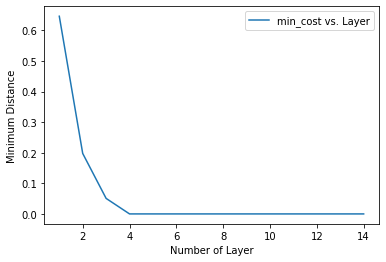

In [ ]:
optimization_ouput(cost_function,15)

The minimum distance becomes stable after $L=4$.

# 4. Try other parametrized gates. <a name="bonus"></a>

Now we will modify the odd blocks while keeping even blocks to be the same. The new oddblocks are parametrized $R_y$ gates operate on each qbit. 

In [5]:
#build the odd blocks of quantum gates
def oddgate_new(given_circuit, theta_list):
    
     #operate parmetrized Rx gates on each qbit
    for i in range(given_circuit.num_qubits):
        given_circuit.ry(theta_list[i],i)
  
    return given_circuit


# visualize the random odd block
print("New odd gate")
oddgate_new(QuantumCircuit(QuantumRegister(4)),theta).draw()

New odd gate


┌──────────┐
q2_0: ┤ RY(θ[0]) ├
      ├──────────┤
q2_1: ┤ RY(θ[1]) ├
      ├──────────┤
q2_2: ┤ RY(θ[2]) ├
      ├──────────┤
q2_3: ┤ RY(θ[3]) ├
      └──────────┘

Optimization:

In [ ]:
#bulid L layers of odd and even blocks for a 4 qbit quantum circuit
def get_var_form1( parameters, L ):
    #initiallize a quantm circuit with 4 qbits, and its parameters with respect to layer L
    mycircuit = QuantumCircuit(QuantumRegister(4))
    parameter = parameters.reshape((L,8))

    #add L layers of odd and even blocks
    for i in range(L):
        oddgate_new(mycircuit, parameter[i][0:4])
        mycircuit.barrier()
        evengate(mycircuit, parameter[i][4:8])
        mycircuit.barrier()
    return mycircuit


def cost_function1(parameters):  
    
    L=int(len(parameters)/8)  # number of layers
    
    qc = get_var_form1(parameters,L=L)  # define our quantum circuit

    #get the final state using quantum simulator
    final_state = execute(qc, Aer.get_backend("statevector_simulator"), shots=NUM_SHOTS).result().get_statevector()

    # calculate cost function
    cost = sum([(final_state[i] - target_state[i])*np.conjugate(final_state[i] - target_state[i]) for i in range(2**4)])
    return cost

Layer ::  1  Optimized cost:: 0.6129185199951553   Success: True
Layer ::  2  Optimized cost:: 0.2305198755805217   Success: True
Layer ::  3  Optimized cost:: 0.010523847488748433   Success: True
Layer ::  4  Optimized cost:: 3.896195016350906e-05   Success: True
Layer ::  5  Optimized cost:: 2.572957586117772e-07   Success: True
Layer ::  6  Optimized cost:: 7.633956758801334e-08   Success: True
Layer ::  7  Optimized cost:: 2.886527217438489e-07   Success: True
Layer ::  8  Optimized cost:: 5.6521718366522066e-08   Success: True
Layer ::  9  Optimized cost:: 5.80836366950584e-08   Success: True
Layer ::  10  Optimized cost:: 5.5895618049294085e-08   Success: True
Layer ::  11  Optimized cost:: 3.966130293872505e-08   Success: True
Layer ::  12  Optimized cost:: 4.151331707277427e-08   Success: True
Layer ::  13  Optimized cost:: 6.594277432030122e-08   Success: True
Layer ::  14  Optimized cost:: 7.11172027478085e-08   Success: True
Layer scan finished !!!!


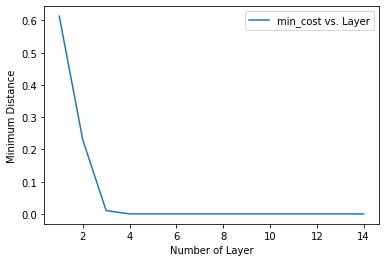

In [ ]:
optimization_ouput(cost_function1,15)

The minimum distance become stable after $L = 4$ which is the same as originial circuit.

# 5. Try different entanglement <a name="entanglement"></a>

In this section we will modify the even blocks and analysis the impact of entanglement.

* We now apply ```CZ``` to only adjacent  qbits in a way similar to the linear entanglement form and visualize the even block.

In [6]:
#build the even blocks of quantum gates
def evengate_new(given_circuit, theta_list ):

    #operate parmetrized Rz gates on each qbit
    for i in range(given_circuit.num_qubits):
        given_circuit.rz(theta_list[i],i)
    
    #operate CZ gates on nearest neighbour qbits
    for i in range(given_circuit.num_qubits -1):
        given_circuit.cz(i,i+1)

    return given_circuit

# visualize the random even block
theta = ParameterVector('θ',length=4)
print("New even blocks with linear entanglement")
evengate_new(QuantumCircuit(QuantumRegister(4)),theta).draw()

New even blocks with linear entanglement


┌──────────┐         
q3_0: ┤ RZ(θ[0]) ├─■───────
      ├──────────┤ │       
q3_1: ┤ RZ(θ[1]) ├─■──■────
      ├──────────┤    │    
q3_2: ┤ RZ(θ[2]) ├────■──■─
      ├──────────┤       │ 
q3_3: ┤ RZ(θ[3]) ├───────■─
      └──────────┘

Layer ::  1  Optimized cost:: 0.5767120630335654   Success: True
Layer ::  2  Optimized cost:: 0.20585453797122497   Success: True
Layer ::  3  Optimized cost:: 0.07227092622133015   Success: True
Layer ::  4  Optimized cost:: 1.9302001915970238e-07   Success: True
Layer ::  5  Optimized cost:: 1.5016476137039602e-07   Success: True
Layer ::  6  Optimized cost:: 1.0070393372766267e-06   Success: True
Layer ::  7  Optimized cost:: 6.428569639161236e-08   Success: True
Layer ::  8  Optimized cost:: 7.369653655319114e-08   Success: True
Layer ::  9  Optimized cost:: 5.901143961702016e-08   Success: True
Layer scan finished !!!!


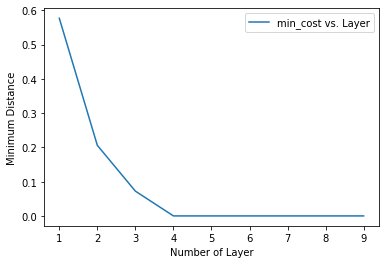

In [ ]:
#bulid L layers of odd and even blocks for a 4 qbit quantum circuit
def get_var_form_entangle( parameters, L ):
    #initiallize a quantm circuit with 4 qbits, and its parameters with respect to layer L
    mycircuit = QuantumCircuit(QuantumRegister(4))
    parameter = parameters.reshape((L,8))

    #add L layers of odd and even blocks
    for i in range(L):
        oddgate(mycircuit, parameter[i][0:4])
        mycircuit.barrier()
        evengate_new(mycircuit, parameter[i][4:8])
        mycircuit.barrier()
    return mycircuit


def cost_function_entangle(parameters):  
    
    L=int(len(parameters)/8)  # number of layers
    
    qc = get_var_form_entangle(parameters,L=L)  # define our quantum circuit

    #get the final state using quantum simulator
    final_state = execute(qc, Aer.get_backend("statevector_simulator"), shots=NUM_SHOTS).result().get_statevector()

    # calculate cost function
    cost = sum([(final_state[i] - target_state[i])*np.conjugate(final_state[i] - target_state[i]) for i in range(2**4)])
    return cost


optimization_ouput(cost_function_entangle,10)

The optimization result become stable after $L = 4$. 

***We can also try to use a parametrized gate with no entanglement.***

In [7]:
#build the even blocks of quantum gates
def evengate_no(given_circuit, theta_list):

    #operate parmetrized Rz gates on each qbit
    for i in range(given_circuit.num_qubits):
        given_circuit.rz(theta_list[i],i)
    
    return given_circuit

# visualize the random even block
theta = ParameterVector('θ',length=4)
print("New even blocks with no entanglement")
evengate_no(QuantumCircuit(QuantumRegister(4)),theta).draw()

New even blocks with no entanglement


┌──────────┐
q4_0: ┤ RZ(θ[0]) ├
      ├──────────┤
q4_1: ┤ RZ(θ[1]) ├
      ├──────────┤
q4_2: ┤ RZ(θ[2]) ├
      ├──────────┤
q4_3: ┤ RZ(θ[3]) ├
      └──────────┘

Layer ::  1  Optimized cost:: 0.5411382055218769   Success: True
Layer ::  2  Optimized cost:: 0.5376931106663716   Success: True
Layer ::  3  Optimized cost:: 0.5376931171951096   Success: True
Layer ::  4  Optimized cost:: 0.5376931358262944   Success: True
Layer ::  5  Optimized cost:: 0.5376930993465089   Success: True
Layer ::  6  Optimized cost:: 0.5376931261362732   Success: True
Layer ::  7  Optimized cost:: 0.5376931076120048   Success: True
Layer ::  8  Optimized cost:: 0.5376931267585064   Success: True
Layer ::  9  Optimized cost:: 0.5376930970161466   Success: True
Layer scan finished !!!!


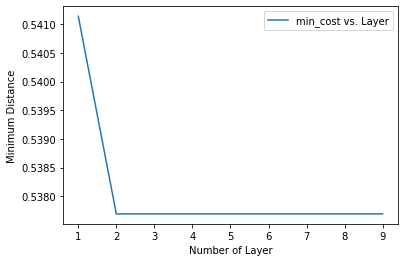

In [ ]:
#bulid L layers of odd and even blocks for a 4 qbit quantum circuit
def get_var_form_noentangle( parameters, L ):
    #initiallize a quantm circuit with 4 qbits, and its parameters with respect to layer L
    mycircuit = QuantumCircuit(QuantumRegister(4))
    parameter = parameters.reshape((L,8))

    #add L layers of odd and even blocks
    for i in range(L):
        oddgate(mycircuit, parameter[i][0:4])
        mycircuit.barrier()
        evengate_no(mycircuit, parameter[i][4:8])
        mycircuit.barrier()
    return mycircuit


def cost_function_noentangle(parameters):  
    
    L=int(len(parameters)/8)  # number of layers
    
    qc = get_var_form_noentangle(parameters,L=L)  # define our quantum circuit

    #get the final state using quantum simulator
    final_state = execute(qc, Aer.get_backend("statevector_simulator"), shots=NUM_SHOTS).result().get_statevector()

    # calculate cost function
    cost = sum([(final_state[i] - target_state[i])*np.conjugate(final_state[i] - target_state[i]) for i in range(2**4)])
    return cost


optimization_ouput(cost_function_noentangle,10)

When there is no entanglment between qbits, the optimization is unstable with a very large error, which indicate this circuit cannot mimic any given random state. 